# まだバグ取り中！

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import random
import cv2


In [10]:
# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ハイパーパラメータの設定
num_epochs = 100
batch_size = 128
learning_rate = 0.001
momentum = 0.9

# CIFAR-10データセットの準備
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Using device: cuda


In [11]:
# Self-Attention層 (変更なし)
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))  # Attention weight
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, C, height, width = x.size()
        proj_query = self.query(x).view(batch_size, -1, height * width).permute(0, 2, 1)  # B x (H*W) x C'
        proj_key = self.key(x).view(batch_size, -1, height * width)  # B x C' x (H*W)
        energy = torch.bmm(proj_query, proj_key)  # batch matrix multiplication: B x (H*W) x (H*W)
        attention = self.softmax(energy)  # B x (H*W) x (H*W)
        proj_value = self.value(x).view(batch_size, -1, height * width)  # B x C x (H*W)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1)).view(batch_size, C, height, width)  # B x C x H x W

        return self.gamma * out + x, attention

# CNNモデルの定義 (pool1とpool3を除去)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, 10)

        # Top-down attention用のパラメータ
        # 修正: 入力チャンネル数を128に変更
        self.td_conv = nn.Conv2d(128, 128, kernel_size=1) # 出力クラス数から特徴マップへ
        self.td_relu = nn.ReLU()
        self.td_upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.td_conv_final = nn.Conv2d(128, 1, kernel_size=1) # 最終的なアテンションマップ

    def forward(self, x):
        conv1_out = self.relu1(self.conv1(x))
        conv2_out = self.relu2(self.conv2(conv1_out))
        pool2_out = self.pool2(conv2_out)
        conv3_out = self.relu3(self.conv3(pool2_out))

        # Top-down attention calculation
        batch_size = x.size(0)
        # 各クラスのロジットを特徴マップの空間に変換 (fc2の出力はまだ計算されていないので、ここでは仮のテンソル)
        # 実際のロジットは fc2 の出力
        # td_input = torch.randn(batch_size, 10, 1, 1).to(x.device) # 仮の入力
        flattened_conv3 = conv3_out.view(batch_size, 128, -1) # B x 128 x (16*16)
        avg_pool_conv3 = torch.mean(flattened_conv3, dim=2).unsqueeze(-1).unsqueeze(-1) # B x 128 x 1 x 1
        td_conv_out = self.td_relu(self.td_conv(avg_pool_conv3)) # B x 128 x 1 x 1
        td_upsampled = self.td_upsample(td_conv_out) # B x 128 x 2 x 2
        h, w = conv3_out.shape[2], conv3_out.shape[3]
        td_upsampled_resized = nn.functional.interpolate(td_upsampled, size=(h, w), mode='bilinear', align_corners=False)
        attention_map = torch.sigmoid(self.td_conv_final(td_upsampled_resized)) # B x 1 x H x W
        attention_map = attention_map.expand_as(conv3_out) # B x 128 x H x W

        # relu3の結果とアテンションマップを乗算
        attended_conv3 = conv3_out * attention_map

        flattened = attended_conv3.view(-1, 128 * 16 * 16)
        fc1_out = self.relu4(self.fc1(flattened))
        logits = self.fc2(fc1_out)

        return logits, attention_map.mean(dim=1) # チャンネル次元を平均して返す

    def get_features(self, x):
        conv1_out = self.relu1(self.conv1(x))
        conv2_out = self.relu2(self.conv2(conv1_out))
        pool2_out = self.pool2(conv2_out)
        conv3_out = self.relu3(self.conv3(pool2_out))
        return conv3_out


In [12]:
# モデルのインスタンス化
net = Net().to(device)

# 損失関数と最適化関数の定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

# 学習の記録用リスト
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# 学習ループ
for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs, _ = net(inputs)  # アテンションマップはここでは使用しない
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

    # テストフェーズ
    net.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs, _ = net(images)  # アテンションマップはここでは使用しない
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss = test_loss / len(testloader)
    test_accuracy = 100 * correct_test / total_test
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

print('Finished Training')



Epoch [1/100], Train Loss: 2.2856, Train Accuracy: 15.88%
Epoch [1/100], Test Loss: 2.2225, Test Accuracy: 24.19%
Epoch [2/100], Train Loss: 2.0822, Train Accuracy: 24.99%
Epoch [2/100], Test Loss: 1.9418, Test Accuracy: 30.64%
Epoch [3/100], Train Loss: 1.9251, Train Accuracy: 30.37%
Epoch [3/100], Test Loss: 1.8045, Test Accuracy: 35.84%
Epoch [4/100], Train Loss: 1.8258, Train Accuracy: 34.25%
Epoch [4/100], Test Loss: 1.6901, Test Accuracy: 39.85%
Epoch [5/100], Train Loss: 1.7423, Train Accuracy: 37.46%
Epoch [5/100], Test Loss: 1.6233, Test Accuracy: 41.84%
Epoch [6/100], Train Loss: 1.6617, Train Accuracy: 40.11%
Epoch [6/100], Test Loss: 1.5374, Test Accuracy: 44.58%
Epoch [7/100], Train Loss: 1.5909, Train Accuracy: 42.60%
Epoch [7/100], Test Loss: 1.4690, Test Accuracy: 47.42%
Epoch [8/100], Train Loss: 1.5385, Train Accuracy: 44.34%
Epoch [8/100], Test Loss: 1.4328, Test Accuracy: 48.31%
Epoch [9/100], Train Loss: 1.4915, Train Accuracy: 45.88%
Epoch [9/100], Test Loss: 1.38

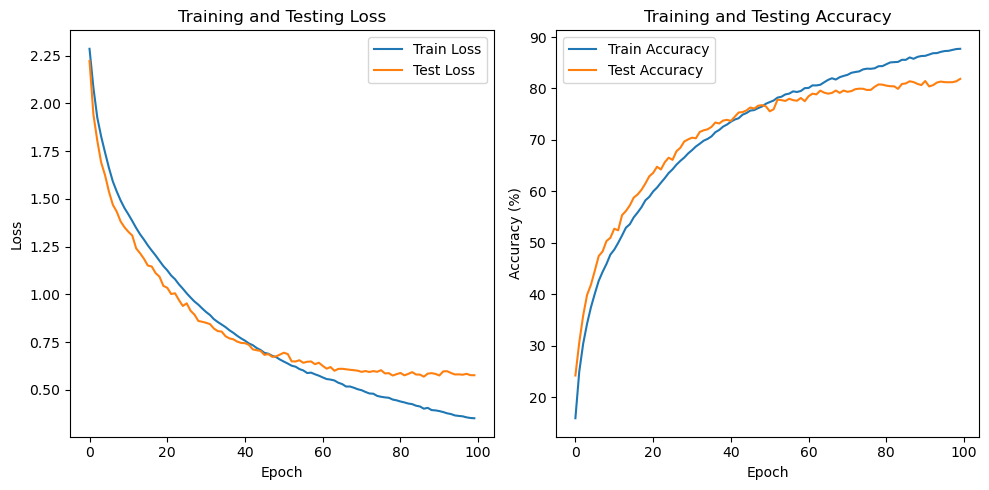

In [13]:
# 学習曲線のプロット (変更なし)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:
# 中間層の特徴ベクトルの可視化
net.eval()
all_features = []
all_labels = []
with torch.no_grad():
    for i, (images, labels) in enumerate(testloader):
        if i >= 10:  # 最初の10バッチのみ使用 (計算量を抑えるため)
            break
        images = images.to(device)
        features = net.get_features(images).cpu().numpy()
        all_features.append(features)
        all_labels.append(labels.cpu().numpy())

all_features = np.concatenate(all_features, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(all_features.reshape(all_features.shape[0], -1)) # 3D特徴マップを2Dに変換

plt.figure(figsize=(8, 6))
colors = plt.cm.get_cmap('tab10', len(classes)) # または plt.cm.get_cmap('Set1', len(classes)) など

for i in range(len(classes)):
    indices = np.where(all_labels == i)[0]
    plt.scatter(principal_components[indices, 0], principal_components[indices, 1],
                label=classes[i], alpha=0.6, c=[colors(i)])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Intermediate Layer Features')
plt.legend()
plt.grid(True)
plt.show()



Visualizing top-down attention for sample with label: truck


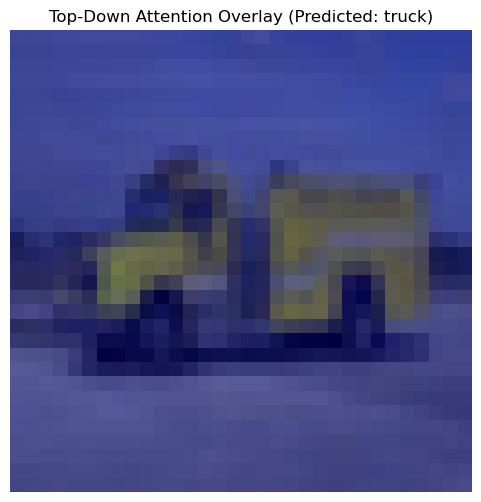

Visualizing top-down attention for sample with label: frog


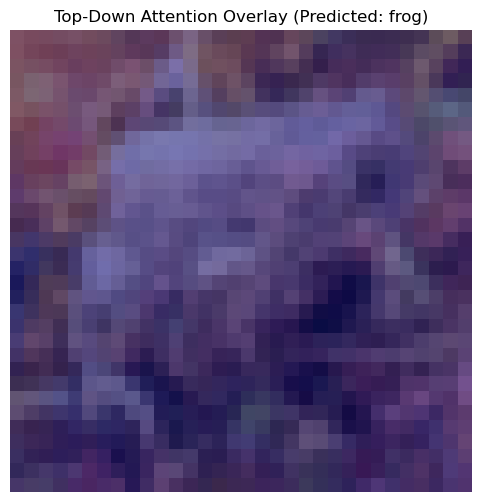

Visualizing top-down attention for sample with label: car


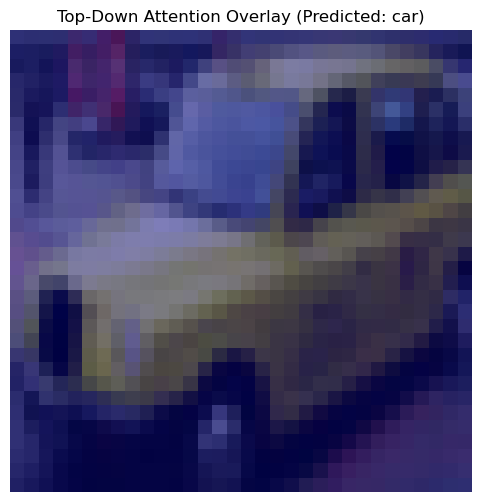

Visualizing top-down attention for sample with label: truck


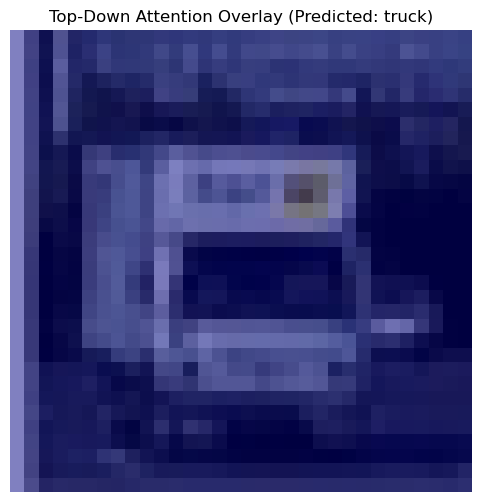

Visualizing top-down attention for sample with label: truck


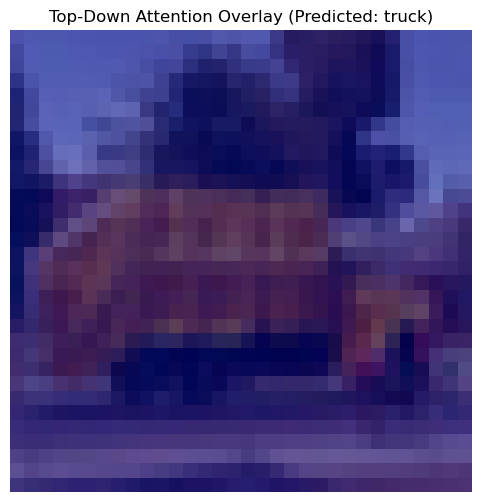

In [ ]:
# 学習後のアテンションの可視化 (変更)
def visualize_attention_on_image(model, image, original_image, class_names):
    model.eval()
    with torch.no_grad():
        # 入力画像をデバイスに移動し、バッチ次元を追加
        image_tensor = image.unsqueeze(0).to(device)
        output, attention_map = model(image_tensor)
        _, predicted_idx = torch.max(output, 1)
        predicted_class = class_names[predicted_idx.item()]

        # アテンションマップをCPUとNumPy配列に移動
        attention_map = attention_map.squeeze(0).cpu().numpy()
        # アテンションマップのサイズは (H x W)
        attn_map = attention_map # 既に (H x W) の形状になっているはず

        # ヒートマップのサイズを入力画像のサイズに合わせる
        original_height, original_width = original_image.shape[1], original_image.shape[2]
        attn_map_resized = cv2.resize(attn_map, (original_width, original_height))

        # 0から1の範囲に正規化
        attn_map_normalized = (attn_map_resized - np.min(attn_map_resized)) / (np.max(attn_map_resized) - np.min(attn_map_resized) + 1e-8) # ゼロ除算回避
        heatmap = cv2.applyColorMap(np.uint8(255 * attn_map_normalized), cv2.COLORMAP_JET)
        heatmap_rgb = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

        # オリジナル画像をRGBに変換
        original_image_rgb = (original_image.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5) * 255
        original_image_rgb = original_image_rgb.astype(np.uint8)

        # サイズが一致しているか確認 (デバッグ用)
        if original_image_rgb.shape[:2] != heatmap_rgb.shape[:2] or original_image_rgb.shape[2] != 3 or heatmap_rgb.shape[2] != 3:
            print(f"Error: Shape mismatch before overlaying.")
            print(f"Original Image Shape: {original_image_rgb.shape}")
            print(f"Heatmap Shape: {heatmap_rgb.shape}")
            return

        # ヒートマップをオーバーレイ
        alpha = 0.5  # 透明度
        overlay = cv2.addWeighted(original_image_rgb, 1 - alpha, heatmap_rgb, alpha, 0)

        plt.figure(figsize=(6, 6))
        plt.imshow(overlay)
        plt.title(f'Top-Down Attention Overlay (Predicted: {predicted_class})')
        plt.axis('off')
        plt.show()

# テストデータからランダムなサンプルを選択
num_samples_to_visualize = 5
indices = random.sample(range(len(testset)), num_samples_to_visualize)
for index in indices:
    img, label = testset[index]
    original_img = img.clone() # 可視化用にオリジナルのテンソルを保持
    class_name = classes[label]
    print(f"Visualizing top-down attention for sample with label: {class_name}")
    visualize_attention_on_image(net, img, original_img, classes)